# Chapter 11. Machine Learning

In [31]:
from __future__ import division
from collections import Counter
import math, random

## Modeling

A model is a specification of a mathematical or probabilistic relationship that exists between different variables.

## What is Machine Learning?

This book defines [machine learning](https://en.wikipedia.org/wiki/Machine_learning) as creating and using models that are learned from data, which in other contexts might be referred to as [predictive modeling](https://en.wikipedia.org/wiki/Predictive_modelling) or [data mining](https://en.wikipedia.org/wiki/Data_mining).  
Typically, our goal will be to use existing data to develop models that we can use to predict various outcomes for new (incoming) data, such as:  
- Predicting whether an email message is spam or not.
- Predicting whether a credit card transaction is fraudulent or not.
- Predicting which advertisement a shopper is most likely to click on.
- Predicting which football team is going to win the Super Bowl.

We will be looking at:  
- Supervised Models in which there is a set of data labeled with the correct answers to learn from.
- Unsupervised Models in which there are no such labels.  
There are other types of machine learning, such as semisupervised and reinforcement, that will not be covered here.  
There are many different machine learning models that might describe the particular problem we're trying to solve or relationship we're trying to find.  
Throughout the rest of this book we'll be investigating different families of models that we can learn, so let's begin by better understanding the fundamentals of machine learning.

## Overfitting and Underfitting

Overfitting happens when you create a model that performs well on the data you train it on but that generalizes poorly to new data.  
Underfitting happens when you create a model that performs poorly on the training data as well.

### Example code and plots from [scikit-learn](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html) website

A detailed explanation can be found below the plots, and the code can be found in the root directory in the file `plot_underfitting_overfitting.py`.

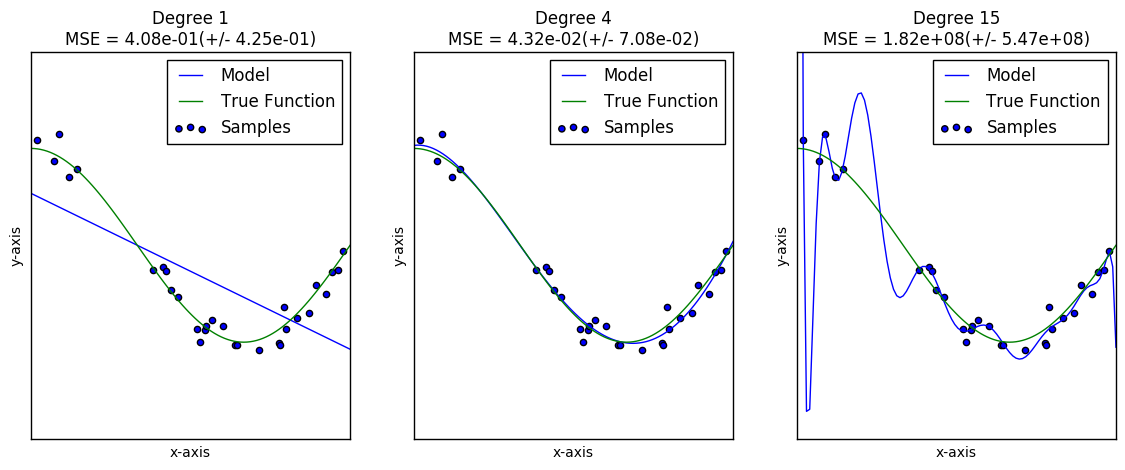

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

true_fun = lambda X: np.cos(1.5 * np.pi * X)
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())
    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    
    # evaluate the models using cross-validation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)
    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True Function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(degrees[i], -scores.mean(), scores.std()))
plt.show()
# The plots below show underfitting on the left, fitting in the center, and overfitting on the right. 

This example demonstrates the problems of underfitting and overfitting and how we can use linear regression with polynomial features to approximate nonlinear functions.  
The plot shows the function that we want to approximate, which is a part of the cosine function.  
In addition, the samples from the real function and the approximations of different models are displayed.  
The models have polynomial features of different degrees.  
We can see that a linear function (polynomial with degree 1) is not sufficient to fit the training samples.  
This is called **underfitting**.  
A polynomial of degree 4 approximates the true function almost perfectly.  
However, for higher degrees (15 in this example) the model will **overfit** the training data, i.e. it 'learns' the noise of the training data.  
We can quantitatively evaluate **overfitting / underfitting** by using cross-validation.  
We calculate the mean squared error (MSE) on the validation set.  
The higher the MSE, the less likely the model generalizes correctly from the training data.

Long story short, models that are too complex lead to overfitting and don't generalize well beyond the data that they were trained on.  
So how do we make sure that our models aren't too complex?  
The most fundamental approach involves using different data to train the model and to test the model.  
The simplest way to do this is to to split your data set so that (for example) two-thirds of the data is used to train the model and the remaining one-third is used for testing (measuring the model's performance):

In [33]:
def split_data(data, prob):
    """ split the data into fractions [prob, 1 - prob] """
    results = [],[]
    for row in data:
        results[0 if random.random() < prob else 1].append(row)
    return results

Often, we'll have a matrix x of input variables and a vector y of output variables.  
In that case, we need to make sure to put corresponding values together in either the training data or the test data:

In [34]:
def train_test_split(x, y, test_pct):
    data = zip(x, y)
    # pair corresponding values
    train, test = split_data(data, 1 - test_pct)
    # split the data set of pairs
    x_train, y_train = zip(*train)
    # un-zip the pairs
    x_test, y_test = zip(*test)
    return x_train, x_test, y_train, y_test

For example, the above code might be executed like this:

If the model performs well on the test data, you can be more confident that the model is *fitting* rather that *overfitting*, but there are still ways that this can go wrong.  
The first is if there are common patterns in the test and train data that don't generalize to a larger data set.  
A bigger problem is if you use the test/train split not just to judge a model but also to choose from among many models.  
In such a situation, you would split the data into *three* parts:
- a training set for building models
- a validation set for choosing among trained models
- a test set for judging the final model

## Correctness

Accuracy is not typically used to measure how good a model is.  
Imagine building a model to make a binary judgment, such as "Is this email message spam?".  
Given a set of labeled data and using a predictive model, every data point lies in one of four categories:
- True Positive: The message is spam and spam was predicted.
- False Positive: The message is *not* spam, but spam was predicted. (Type 1 Error)
- False Negative: The message is spam, but spam was *not* predicted. (Type 2 Error)
- True Negative: The message is *not* spam, and spam was *not* predicted.

These counts can be represented in a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

|                       | Actual Spam    | Actual Not Spam |
|-----------------------|:--------------:|:---------------:|
|**Predicted Spam**     | True Positive  | False Positive  |
|**Predicted Not Spam** | False Negative | True Negative   |

To demonstrate why measuring accuracy can be misleading, let's use an example:  
Predict whether or not a child has leukemia if and only if the baby is named 'Luke'.  
Approximately [5 babies out of 1000 are named Luke](http://www.babycenter.com/babyNameAllPops.htm?babyNameId=2918).  
The lifetime prevalence of leukemia is about 1.4%, or [14 out of every 1000 people](https://seer.cancer.gov/statfacts/html/leuks.html).  
Assuming that those two factors are independent, let's apply our test to 1 million people.  
Our confusion matrix should look something like this:

|             | Leukemia | Not Leukemia  |Total     |
|-------------|:--------:|:-------------:|:--------:|
|**Luke**     | 70       | 4930          | 5000     |
|**Not Luke** | 13,930   | 981,070       | 995,000  |
|**Total**    | 14,000   | 986,000       | 1,000,000|

We can then use these figures to compute various statistics about model performance.  
*Accuracy* is defined as the fraction of correct predictions:

In [35]:
def accuracy(tp, fp, fn, tn):
    correct = tp + tn
    total = tp + fp + fn + tn
    return correct / total

accuracy(70, 4930, 13930, 981070)

0.98114

98% accuracy is a good number, but the Luke/Leukemia test is not a very good one, so we should probably not give much credence to raw accuracy.  
Instead, it is common to look at the combination of [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall).  
Precision measures how accurate the *positive* predictions are:

In [36]:
def precision(tp, fp, fn, tn):
    return tp / (tp + fp)

precision(70, 4930, 13930, 981070)

0.014

Recall measures what fraction of the positives the model identified:

In [37]:
def recall(tp, fp, fn, tn):
    return tp / (tp + fn)

recall(70, 4930, 13930, 981070)

0.005

Both the precision and recall numbers for the Luke/Leukemia model are very low, indicating that the model is pretty bad.  
Sometimes precision and recall are combined into the [F1 score](https://en.wikipedia.org/wiki/F1_score), which is the [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of precision and recall that lies between them:

In [38]:
def f1_score(tp, fp, fn, tn):
    p = precision(tp, fp, fn, tn)
    r = recall(tp, fp, fn, tn)
    return 2 * p * r / (p + r)

f1_score(70, 4930, 13930, 981070)

0.00736842105263158

Usually the choice of a model involves a trade-off between precision and recall, which can be thought of as a trade-off between false positives and false negatives.  
If you imagine that there are 10 risk factors for leukemia, you can develop a continuum of tests that will allow you to increase precision and decrease recall.

## The Bias-Variance Trade-Off